In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '16'
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pybnesian as pbn
import pickle
import scikit_posthocs as sp
from statds.no_parametrics import friedman, hommel
from critical_diagrams_2d import Diagrams

In [2]:
methodLocDict = {
                '$k$NNCIT': './results/synthetic/knncit/hspbns/',
                 'MRCIT': './results/synthetic/mrcit/hspbns/',
                 'HC': './results/synthetic/hillclimbing/',
                 'MMCIT': './results/synthetic/mmcit/hspbns/',
                 'CGIT': './results/synthetic/cgit/hspbns/',
                 'DGCIT': './results/synthetic/dgcit/hspbns/',
                }
groundTruthLoc = './hspbns/'

## Parameter Learning

In [3]:
def preprocess_dataset(filename):
    df = pd.read_csv('./datasets/synthetic/'+ filename)

    cat_data = df.select_dtypes('int64').astype('str').astype('category')
    for c in cat_data:
        df = df.assign(**{c: cat_data[c]})
    float_data = df.select_dtypes('number').astype('float64')
    for c in float_data:
        df = df.assign(**{c: float_data[c]})

    node_children_blacklist = []
    for source in df.columns:
        for target in df.columns:
            if source != target and df[target].dtype == 'category' and df[source].dtype == 'float64':
                
                node_children_blacklist.append(
                    [source, target])
                
    return df, node_children_blacklist

In [4]:
try:
    results = pd.read_csv('./results/synthetic/results_params.csv')
except:
    results = pd.DataFrame(columns=['method', 'n_rep', 'n_vars', 'discrete_ratio', 'kde_ratio', 'edge_density', 'samples'])
  


In [ ]:
entry = []
for graphFile in sorted(os.listdir(groundTruthLoc))[:]:
    splitted = graphFile.split('_')
    n_rep = splitted[0]
    n_vars = splitted[1]
    discrete_ratio = splitted[2].replace('p','.')
    kde_ratio = splitted[3].replace('p','.')
    edge_density = splitted[4].replace('p','.')[:-4]
   
    df_test_og, _ = preprocess_dataset('test/' + graphFile[:-4] + '_1000.csv')

    for samples in ['150', '375', '750', '1500', '3000']:

        df, _ = preprocess_dataset(graphFile[:-4] + '_' + samples + '.csv')

        # remove unseen values during training that make the likelihood be -inf
        df_test = df_test_og.copy()
        category_cols = df_test.select_dtypes('category').columns
        for col in category_cols:
            valid_values = df[col].unique()
            df_test = df_test.loc[df_test[col].isin(valid_values), :]
            df_test[col] = df_test[col].cat.set_categories(df[col].cat.categories)
        
        for method in methodLocDict.keys():
            if len(results.loc[(results['method'] == method) & (results['n_rep'] == int(n_rep)) &(results['n_vars'] == int(n_vars)) &(results['discrete_ratio'] == float(discrete_ratio)) &(results['kde_ratio'] == float(kde_ratio)) &(results['edge_density'] == float(edge_density)) &(results['samples'] == int(samples))]) > 0:
                    continue
            try:
                if method == '$HC$':
                    with open(methodLocDict[method]+ graphFile[:-4]+ '_' + samples+'.pkl', "rb") as f:
                        learned_spbn = pickle.load(f)
                else:
                    with open(methodLocDict[method]+ graphFile[:-4]+ '_' + samples+'.pickle', "rb") as f:
                        learned_spbn = pickle.load(f)
                
                # fit to training dataset
                learned_spbn.fit(df)
                # evaluate over test dataset
                logl = learned_spbn.logl(df_test)
                slogl = np.nansum(logl[np.where(~np.isinf(logl))[0]])
                
                results = pd.concat([results, pd.DataFrame([[method, n_rep, n_vars, discrete_ratio, kde_ratio, edge_density, samples, slogl]], columns = ['method', 'n_rep', 'n_vars', 'discrete_ratio', 'kde_ratio', 'edge_density', 'samples', 'LOGL'])])
                results.to_csv('./results/synthetic/results_params.csv', index=False)

            except Exception as e:
                print("Error in", method, graphFile)
                print(e, flush=True)


#### Critical difference diagram 

In [5]:
def create_symmetric_matrix(comparisons_df):
    # Extract all unique methods from comparisons
    methods = set()
    for comp in comparisons_df['Comparison']:
        a, b = comp.split(' vs ')
        methods.update([a, b])
    methods = sorted(methods)  # Sort for consistent order
    
    # Initialize matrix with 1.0 on diagonal and 0.0 for first row/column
    n = len(methods) + 1  # +1 for index column
    mat = np.zeros((n, n))
    np.fill_diagonal(mat, 1.0)
    
    # Create index names
    index_names = ['index'] + methods
    
    # Create mapping from comparison to adjusted p-value
    pvalue_map = {}
    for _, row in comparisons_df.iterrows():
        a, b = row['Comparison'].split(' vs ')
        pvalue_map[(a, b)] = row['Adjusted p-value']
        pvalue_map[(b, a)] = row['Adjusted p-value']  # Symmetric
    
    # Fill the matrix
    for i, method1 in enumerate(methods, start=1):
        for j, method2 in enumerate(methods, start=1):
            if i != j:  # Skip diagonal
                mat[i, j] = pvalue_map.get((method1, method2), 0.0)
    
    # Set first row and column to 0 (except diagonal)
    mat[0, 1:] = 0.0
    mat[1:, 0] = 0.0
    
    # Create DataFrame
    return pd.DataFrame(mat, index=index_names, columns=index_names)

In [6]:
crit_diagram_dfs = list()
results = pd.read_csv('./results/synthetic/results_params.csv')

df = results.loc[np.where(results.method.isin(list(methodLocDict.keys())))[0], :]
pivoted_df = df.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio', 'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='LOGL'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = -np.inf
crit_diagram_dfs.append(pivoted_df)

df = results.loc[np.where(results.method.isin(list(methodLocDict.keys())))[0], :]
df = df.loc[(df.discrete_ratio == 0.1) & (df.kde_ratio == 1), :]
pivoted_df = df.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio', 'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='LOGL'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = -np.inf
crit_diagram_dfs.append(pivoted_df)

df = results.loc[np.where(results.method.isin(list(methodLocDict.keys())))[0], :]
df = df.loc[(df.discrete_ratio == 0.1) & (df.kde_ratio == 0), :]
pivoted_df = df.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio', 'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='LOGL'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = -np.inf
crit_diagram_dfs.append(pivoted_df)

df = results.loc[np.where(results.method.isin(list(methodLocDict.keys())))[0], :]
df = df.loc[(df.discrete_ratio == 0.9), :]
pivoted_df = df.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio', 'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='LOGL'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = -np.inf
crit_diagram_dfs.append(pivoted_df)


In [7]:
color_map = {
    '$k$NNCIT': 'tab:red',
    'MRCIT':    'tab:blue',
    'HC':       'tab:green',
    'MMCIT':    'tab:purple',
    'CGIT':     'tab:orange',
    'DGCIT':    'tab:cyan'
}

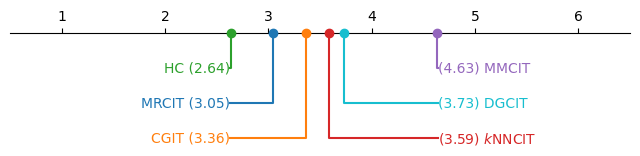

In [8]:
for i in range(4):
    rankings, statistic, p_value, critical_value, hypothesis = friedman(crit_diagram_dfs[i], alpha = 0.05, minimize=False, verbose=False)
    num_cases = pivoted_df.shape[0]
    results, _ = hommel(ranks=rankings, num_cases=num_cases, alpha=0.05, control = None, type_rank = "Friedman", verbose=False)
    plt.close()
    plt.figure(figsize=(8, 1.5), dpi=100)

    sp.critical_difference_diagram(rankings, create_symmetric_matrix(results), label_fmt_left='{label} ({rank:.3g})', label_fmt_right='({rank:.3g}) {label}',color_palette=color_map)

    plt.xlim(0.5,6.5)
    plt.savefig(f'./results/synthetic/CDD_LOGLSYNTH_{i+1}.eps', format = 'eps', bbox_inches='tight')

#### 2D critical difference diagram

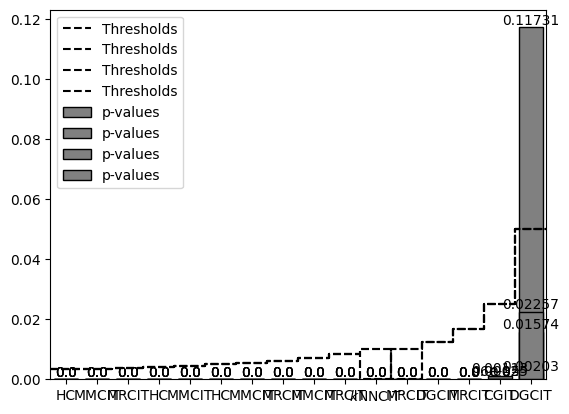

In [9]:
two_dimensional_diagram = Diagrams(
    crit_diagram_dfs,
    diagram_names = ['Average', 'High KDE ratio', 'Low KDE ratio', 'High discr. ratio'],
    treatment_names = pivoted_df.columns[1:],
    maximize_outcome = True
)

In [11]:
two_dimensional_diagram.to_file(
    "./results/synthetic/2d_logl_synth.pdf",
    preamble="\n".join([  # colors are defined before \begin{document}
        "\\definecolor{color1}{HTML}{84B818}",  # green
        "\\definecolor{color2}{HTML}{D18B12}",  # orange
        "\\definecolor{color3}{HTML}{1BB5B5}",  # teal
        "\\definecolor{color4}{HTML}{F85A3E}",  # red
        "\\definecolor{color5}{HTML}{4B6CFC}",  # blue
        "\\definecolor{color6}{HTML}{A347BA}",  # purple
        "\\definecolor{color7}{HTML}{FFD700}",  # gold
        "\\definecolor{color8}{HTML}{FF69B4}",  # pink
        "\\definecolor{color9}{HTML}{00CED1}",  # dark turquoise
    ]),
    axis_options={  # style the plot
        "cycle list": ",".join([  # define the markers for treatments
            "{color1,mark=*}",                     # circle
            "{color2,mark=square*}",               # square
            "{color3,mark=diamond*}",              # diamond
            "{color4,mark=triangle*}",              # triangle
            "{color5,mark=pentagon*}",             # pentagon
            "{color6,mark=otimes*}",               # circled times
            "{color7,mark=star,semithick}",        # star
            "{color8,mark=Mercedes star flipped}", # Mercedes star
            "{color9,mark=halfcircle*}",           # half circle
        ]),
        "width": "0.9*\\axisdefaultwidth",
        "height": "0.75*\\axisdefaultheight",
        "title": "Critical difference diagrams for SPBN LOGL"
    },
)

In [12]:
pivoted_df = df.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio',
           'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='LOGL'
).reset_index(drop=True)
np.isnan(pivoted_df).sum()

method
$k$NNCIT     0
CGIT         0
DGCIT       22
HC           0
MMCIT        6
MRCIT        0
dtype: int64